In [1]:

import logging
import os
from math import floor
from typing import Optional
import time
from tqdm import tqdm, trange

import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import levy_stable

import pyro
import pyro.distributions as dist
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete

from pyro.infer.reparam import MinimalReparam, StableReparam
from pyro.ops.indexing import Vindex
from pyro import poutine

from emsim.io.realimages import read_images
from emsim.stable_dist import StableWithLogProb, Batch1DIntegrator

torch.autograd.set_detect_anomaly(True)

In [2]:
def test_logprob(alpha, beta, scale, loc, n):
    dist = StableWithLogProb(alpha, beta, scale, loc)
    x = dist.sample((n,))
    
    t0 = time.time()
    torch_log_prob = dist.log_prob(x)
    t_torch = time.time() - t0
    print(f"Torch time = {t_torch}")
    print(f"{torch_log_prob=}")
    
    t0 = time.time()
    torch_log_prob = dist.log_prob(x)
    t_torch = time.time() - t0
    print(f"Torch time 2 = {t_torch}")
    print(f"{torch_log_prob=}")
    
    t0 = time.time()
    levy_stable.parameterization = "S0"
    scipy_log_prob = levy_stable.logpdf(x.numpy(), dist.stability.numpy(), dist.skew.numpy(), scale=dist.scale.numpy(), loc=dist.loc.numpy())
    t_scipy = time.time() - t0
    print(f"Scipy time = {t_scipy}")
    print(f"{scipy_log_prob=}")

    print(f"{np.allclose(torch_log_prob.numpy(), scipy_log_prob)=}")
    

In [3]:
test_logprob(1.8, 0.4, 2.5, 3., 10)

Torch time = 0.3182039260864258
torch_log_prob=tensor([-2.4294, -4.4789, -2.1825, -2.1833, -2.7090, -2.3459, -2.5216, -3.2681,
        -2.1857, -2.5038], dtype=torch.float64)
Torch time 2 = 0.005805015563964844
torch_log_prob=tensor([-2.4294, -4.4789, -2.1825, -2.1833, -2.7090, -2.3459, -2.5216, -3.2681,
        -2.1857, -2.5038], dtype=torch.float64)
Scipy time = 0.01503300666809082
scipy_log_prob=array([-2.42936356, -4.47891235, -2.18254257, -2.18333047, -2.70904206,
       -2.34588022, -2.5216481 , -3.2680828 , -2.18566707, -2.50384101])
np.allclose(torch_log_prob.numpy(), scipy_log_prob)=True


/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/autoray/autoray.py:80: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  return get_lib_fn(backend, fn)(*args, **kwargs)
/Users/mawright/Code/emsim/emsim/stable_dist/integrator.py:18: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert integration_domain.shape[-1] == 2
/Users/mawright/Code/emsim/emsim/stable_dist/integrator.py:117: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you us

In [4]:
def nll_loss(dist: StableWithLogProb, data: torch.Tensor, use_compiled_integrate=True):
    ll = dist.log_prob(data).sum()
    return -ll

In [5]:
class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self._raw_alpha = nn.Parameter(torch.randn((1,)))
        self._raw_beta = nn.Parameter(torch.randn((1,)))
        self._raw_scale = nn.Parameter(torch.randn((1,)))
        self.loc = nn.Parameter(torch.randn(1,))
        
        self.integrator = Batch1DIntegrator()
        
    @property
    def alpha(self):
        return torch.sigmoid(self._raw_alpha) * 2
    
    @property
    def beta(self):
        return torch.sigmoid(self._raw_beta) * 2 - 1
        
    @property
    def scale(self):
        return torch.exp(self._raw_scale)
        
    def params(self):
        return (
            self.alpha, self.beta, self.scale, self.loc
        )

In [6]:
torch.manual_seed(123)
# true = dist.Stable(1.8, 0.4, 2.5, 3.)
true = dist.Stable(1.1, 0.8, 2.5, 1)
module = MyModule()

In [7]:
X = torch.randn(100,100) * 1e30

In [8]:
X.max()

tensor(3.8954e+30)

In [9]:
Y = X * torch.exp(-X)

In [10]:
Y.isnan().nonzero()

tensor([], size=(0, 2), dtype=torch.int64)

In [11]:
num_steps = 30000
optim = torch.optim.Adam(module.parameters())
losses = []
gradients = []
param_values = []
param_errors = []
torch.manual_seed(123)
with trange(num_steps) as pbar:
    true_params = np.array([true.stability.item(), true.skew.item(), true.scale.item(), true.loc.item()])
    for i in pbar:
        t0 = time.time()
        data = true.sample((1000,))
        optim.zero_grad()
        training_dist = StableWithLogProb(module.alpha, module.beta, module.scale, module.loc, integrator=module.integrator)
        loss = nll_loss(training_dist, data)

        loss.backward()
        with torch.no_grad():
            grad_t = [param.grad.item() for param in module.parameters()]

        gradients.append(grad_t)

        optim.step()

        losses.append(loss.item())
        with torch.no_grad():
            params_t = np.array([param.item() for param in module.params()])
        param_values.append(params_t)
        
        param_error = np.linalg.norm(params_t - true_params, 1)
        param_errors.append(param_error)
        
        t_iter = time.time() - t0
        
        pbar.set_postfix(loss=losses[-1], param_error=param_error, iter_time=t_iter)

  0%|          | 0/30000 [00:00<?, ?it/s]

/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/torch/jit/_trace.py:154: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/build/aten/src/ATen/core/TensorBody.h:491.)
  if a.grad is not None:
 32%|███▏      | 9558/30000 [11:12<23:21, 14.59it/s, iter_time=0.0668, loss=3.35e+3, param_error=0.767]/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in LogBackward0. Traceback of forward call that caused the error:
  File "<frozen 

RuntimeError: Function 'LogBackward0' returned nan values in its 0th output.

In [15]:
(-training_dist.log_prob(data)).sum().backward()

/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/autoray/autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)
/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/torch/autograd/__init__.py:200: UserWarning: Error detected in LogBackward0. Traceback of forward call that caused the error:
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/Users/mawright/micromamba/envs/emsim/lib/python3.11/

RuntimeError: Function 'LogBackward0' returned nan values in its 0th output.

In [8]:
per_param_errors = np.abs(np.array(param_values) - true_params)

Text(0.5, 1.0, 'Parameter estimation errors')

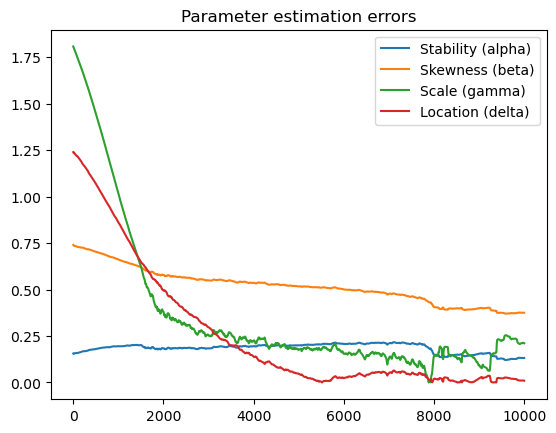

In [9]:
plt.plot(per_param_errors, label=["Stability (alpha)", "Skewness (beta)", "Scale (gamma)", "Location (delta)"])
plt.legend()
plt.title("Parameter estimation errors")

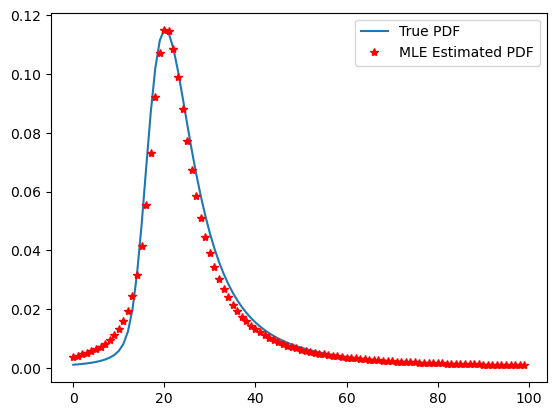

In [10]:
true_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), true.stability.item(), true.skew.item(), loc=true.loc.item(), scale=true.scale.item())
estimated_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), param_values[-1][0], param_values[-1][1], scale=param_values[-1][2], loc=param_values[-1][3])
plt.plot(true_pdf)
plt.plot(estimated_pdf, "r*")
plt.legend(["True PDF", "MLE Estimated PDF"])

Text(0.5, 1.0, 'Parameter estimation errors')

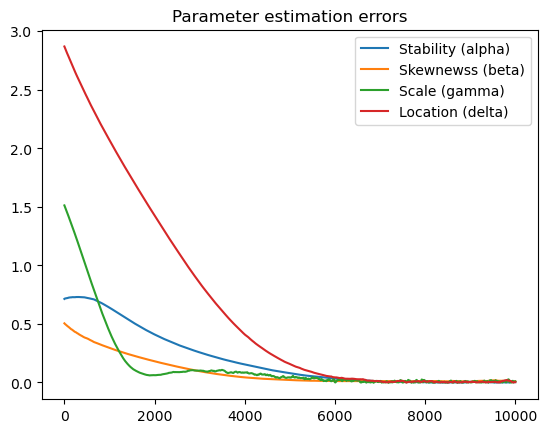

In [ ]:
plt.plot(per_param_errors, label=["Stability (alpha)", "Skewness (beta)", "Scale (gamma)", "Location (delta)"])
plt.legend()
plt.title("Parameter estimation errors")

In [43]:
true_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), true.stability.item(), true.skew.item(), loc=true.loc.item(), scale=true.scale.item())
estimated_pdf = levy_stable.pdf(np.linspace(-10, 40, 100), param_values[-1][0], param_values[-1][1], scale=param_values[-1][2], loc=param_values[-1][3])

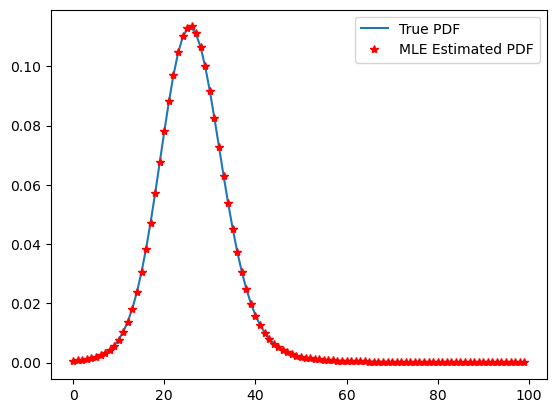

In [45]:
plt.plot(true_pdf)
plt.plot(estimated_pdf, "r*")
plt.legend(["True PDF", "MLE Estimated PDF"])

In [30]:
module.beta

tensor([0.4023], grad_fn=<SubBackward0>)

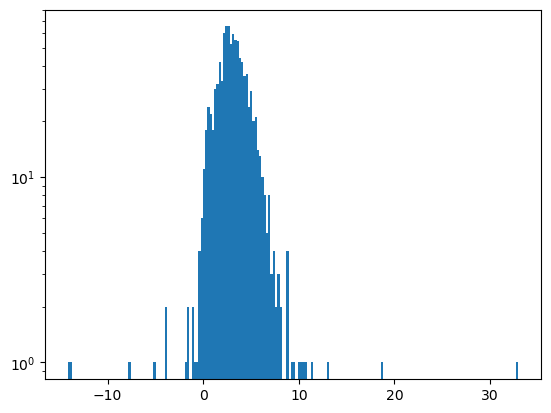

In [2]:
alpha = 1.7
beta = 0.5
c = 1.1
mu = 3
n = 1000

data = dist.Stable(alpha, beta, c, mu).sample((n,))

_ = plt.hist(data, log=True, bins=200)

In [3]:
pyro.clear_param_store()

def simple_model(data):
    # alpha = pyro.sample("alpha", dist.Uniform(0, 2))
    # beta = pyro.sample("beta", dist.Uniform(-1, 1))
    # c = pyro.sample("c", dist.LogNormal(1, 1))
    # mu = pyro.sample("mu", dist.Normal(0, 1))
    
    alpha = pyro.param("alpha", torch.tensor(0.8), constraint=constraints.interval(0, 2))
    beta = pyro.param("beta", torch.tensor(0.7), constraint=constraints.interval(-1, 1))
    c = pyro.param("c", torch.tensor(0.9), constraint=constraints.positive)
    mu = pyro.param("mu", torch.tensor(0.5), constraint=constraints.real)
    
    with pyro.plate("data", data.shape[0], subsample_size=10) as ind:
        # with poutine.reparam(config={"obs": StableReparam()}):
        pyro.sample("obs", StableWithLogProb(alpha, beta, c, mu), obs=data[ind])

In [4]:
guide = pyro.infer.autoguide.AutoNormal(simple_model)

In [5]:
elbo = Trace_ELBO()
elbo.loss(simple_model, guide, data=data)

/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1682343668887/work/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/mawright/micromamba/envs/emsim/lib/python3.11/site-packages/autoray/autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)


29.786555111588815

In [3]:
num_steps = 10
optim = pyro.optim.ClippedAdam({"lr": 0.01})
svi = SVI(simple_model, guide, optim, loss=elbo)

NameError: name 'simple_model' is not defined

In [3]:
losses = []
for i in range(num_steps):
    loss = svi.step(data.flatten())
    losses.append(loss)
    print(loss)
    
plt.plot(losses)
plt.semilogy()

print(f"Parameter estimates (n = {n}):")
print(f"alpha: Estimate = {pyro.param('alpha')}, true = {alpha}")
print(f"beta: Estimate = {pyro.param('beta')}, true = {beta}")
print(f"c: Estimate = {pyro.param('c')}, true = {c}")
print(f"mu: Estimate = {pyro.param('mu')}, true = {mu}")

NameError: name 'num_steps' is not defined

In [14]:
param_values[-1]

[tensor([1.0115]), tensor([-0.4681]), tensor([3.0423]), tensor([1.2427])]

[[tensor([-20.2261]),
  tensor([-17.5532]),
  tensor([-7.2629]),
  tensor([115.0304])]]

In [10]:
pdf = levy_stable.fit(data)


KeyboardInterrupt: 

In [93]:
guide(data)

{'obs_z_uniform': tensor([-1.5161, -1.4626, -1.5106,  ..., -1.4571, -1.5130, -1.4529],
        grad_fn=<ExpandBackward0>),
 'obs_z_exponential': tensor([1.8624, 1.8157, 1.5977,  ..., 1.4886, 1.9162, 1.6965],
        grad_fn=<ExpandBackward0>),
 'obs_t_uniform': tensor([ 1.3646e-01,  5.9456e-01,  5.9597e-01,  ...,  8.4970e-01,
          3.3629e-01, -1.6594e-04], grad_fn=<ExpandBackward0>),
 'obs_t_exponential': tensor([0.2272, 0.2657, 0.3017,  ..., 0.2899, 0.2254, 0.1590],
        grad_fn=<ExpandBackward0>)}

In [84]:
pyro.param("mu")

tensor(1.0205, requires_grad=True)

In [80]:
pyro.get_param_store().named_parameters()

dict_items([('alpha', tensor(-1.9659, requires_grad=True)), ('beta', tensor(-0.4403, requires_grad=True)), ('c', tensor(0.4941, requires_grad=True)), ('mu', tensor(1.0205, requires_grad=True)), ('AutoDelta.obs_z_uniform', Parameter containing:
tensor([-4.4459, -5.3120, -4.1231,  ..., -3.8637, -1.8535, -3.6314],
       requires_grad=True)), ('AutoDelta.obs_z_exponential', Parameter containing:
tensor([ 0.6601,  0.9726,  0.1371,  ..., -0.3287, -1.1482, -0.4288],
       requires_grad=True)), ('AutoDelta.obs_t_uniform', Parameter containing:
tensor([ 0.7717,  0.5261, -4.0246,  ..., -4.2581, -2.3831, -3.8088],
       requires_grad=True)), ('AutoDelta.obs_t_exponential', Parameter containing:
tensor([-1.6110, -1.5156, -1.1283,  ..., -1.5175, -2.2237, -1.6023],
       requires_grad=True))])

In [98]:
pyro.clear_param_store()

def gaussian_model(data):
    mu = pyro.sample("gaussian_mean", dist.Normal(0, 1))
    sigma = pyro.sample("gaussian_sigma", dist.LogNormal(1, 1))
    
    with pyro.plate("data", data.shape[0]):
        pyro.sample("obs", dist.Normal(mu, sigma), obs=data)

data = simulate_data((10000,), 0., noise_sigma=1)

gaussian_guide = pyro.infer.autoguide.AutoDelta(gaussian_model)

elbo = Trace_ELBO()
elbo.loss(gaussian_model, gaussian_guide, data=data)

17897.146484375

In [99]:
pyro.get_param_store().named_parameters()

dict_items([('AutoDelta.gaussian_mean', Parameter containing:
tensor(0.2505, requires_grad=True)), ('AutoDelta.gaussian_sigma', Parameter containing:
tensor(0.7538, requires_grad=True))])

In [100]:
num_steps = 500
optim = pyro.optim.ClippedAdam({"lr": 0.01, "betas": [0.9, 0.99], "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(gaussian_model, gaussian_guide, optim, loss=elbo)

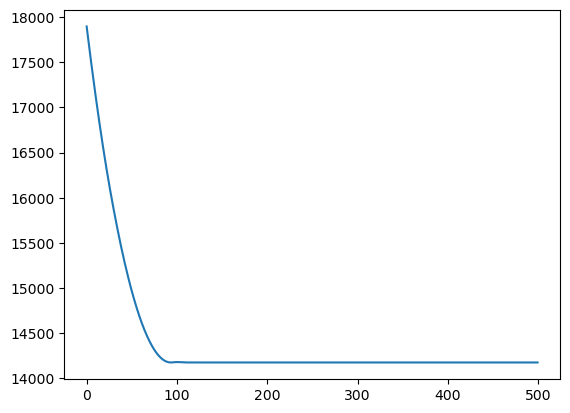

In [101]:
losses = []
for i in range(num_steps):
    loss = svi.step(data)
    losses.append(loss)
    
plt.plot(losses)

In [7]:
out = model(data)

In [8]:
elbo = TraceEnum_ELBO(strict_enumeration_warning=True, max_plate_nesting=3)

In [1]:
from scipy.stats import levy_stable

In [2]:
x = levy_stable.pdf(1, 1.1, 0.8, 1, 1)

In [3]:
np.reshape([1], (1, -1))

NameError: name 'np' is not defined